In [43]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
df = pd.read_csv('time_series/Data/Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


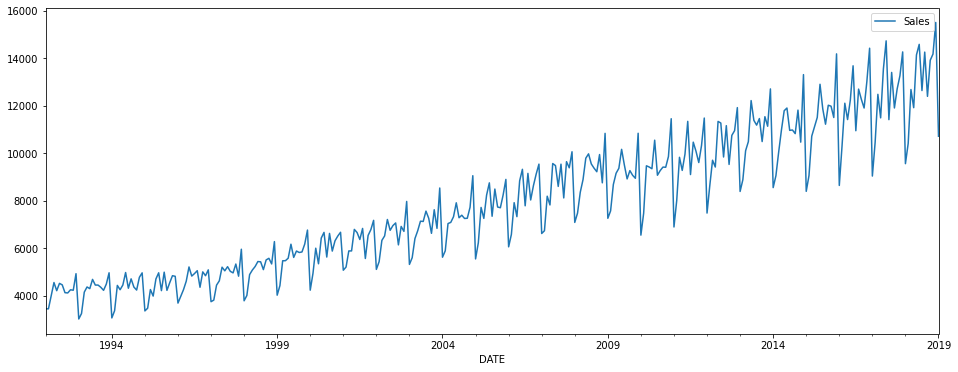

In [22]:
df.columns = ['Sales']
df.plot(figsize=(16,6));

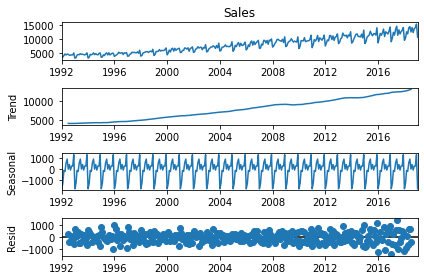

In [23]:
results = seasonal_decompose(df['Sales'])
results.plot();

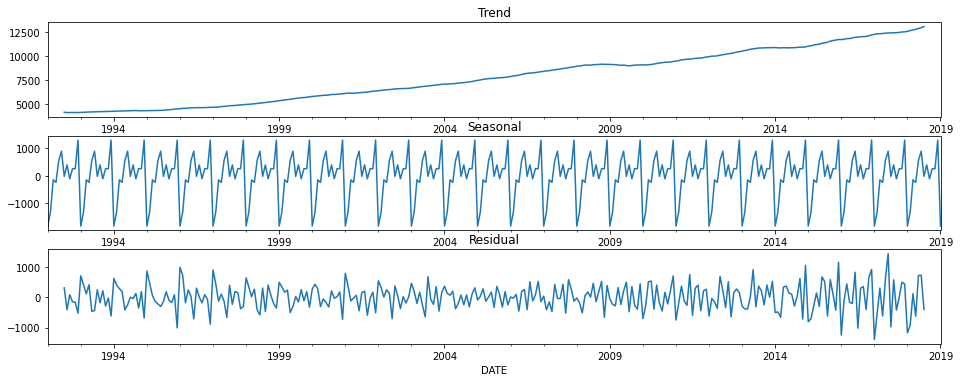

In [24]:
results = seasonal_decompose(df['Sales'])
plt.figure(figsize=(16, 8))

# Plot the decomposition results
ax1 = plt.subplot(411)
results.trend.plot(ax=ax1)
plt.title("Trend")

ax2 = plt.subplot(412)
results.seasonal.plot(ax=ax2)
plt.title("Seasonal")

ax3 = plt.subplot(413)
results.resid.plot(ax=ax3)
plt.title("Residual");

In [25]:
results.seasonal.nunique()

12

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
train = df.iloc[:313]
test = df.iloc[313:]
#scaling the data by dividing by max value
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [40]:
#time series generator to fed into RNN network
#t1-t2-t3-t4-t5-t6 ----> t7
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=2)
len(generator), len(scaled_train) #batch_size should be smaller to prevent overfitting

(156, 313)

In [36]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [72]:
X,y = generator[0]
X, X.shape, y.shape # middle 2 is the no of timesteps

(array([[[0.03658432],
         [0.03649885]],
 
        [[0.03649885],
         [0.08299855]]]),
 (2, 2, 1),
 (2, 1))

In [42]:
y #predicting the 3rd timestamp with 2 n_input from generator

array([[0.08299855],
       [0.13103684]])

In [76]:
n_input = 12
n_features = 1
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1) 

In [77]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1)) #to aggregate the neurons to a single prediction
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150)               91200     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.fit(train_generator, epochs=25)

Epoch 1/25
301/301 [==============================] - 7s 13ms/step - loss: 0.0166
Epoch 2/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0098
Epoch 3/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0093
Epoch 4/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0082
Epoch 5/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0076
Epoch 6/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0064
Epoch 7/25
301/301 [==============================] - 4s 12ms/step - loss: 0.0049
Epoch 8/25
301/301 [==============================] - 4s 13ms/step - loss: 0.0036
Epoch 9/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0030
Epoch 10/25
301/301 [==============================] - 4s 12ms/step - loss: 0.0031
Epoch 11/25
301/301 [==============================] - 4s 12ms/step - loss: 0.0025
Epoch 12/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0025
Epoch 13/25
3

In [79]:
model.history.history.keys()

dict_keys(['loss'])

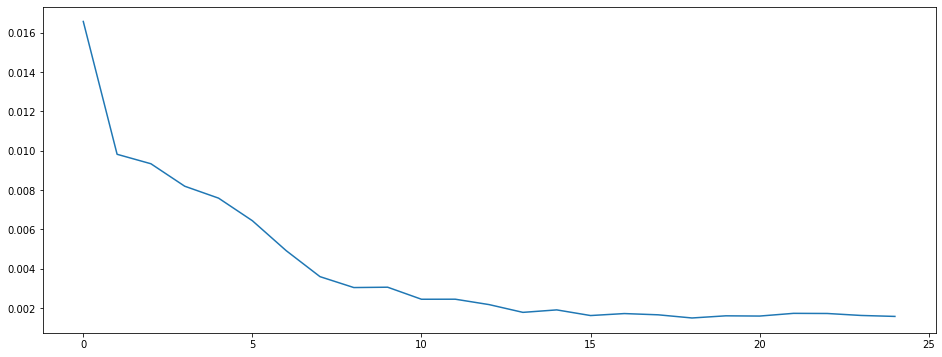

In [80]:
model.history.history['loss']
plt.figure(figsize=(16,6))
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [84]:
#12 history steps ----> predict step 13
#Last 12 points train --> point 1 of test data 
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [87]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features)) #to reshape into 3dimensional array
first_eval_batch.shape

(1, 12, 1)

In [88]:
model.predict(first_eval_batch)[0]

1/1 [==============================] - 0s 56ms/step


array([0.7570245], dtype=float32)

In [89]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

## Forecast using LSTM model

In [98]:
test_predictions = []
# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
#reshape to the format which LSTM  wants(same as Timeseriesgenerator output)
current_batch = first_eval_batch.reshape((1,n_input,n_features))
current_batch.shape

(1, 12, 1)

In [92]:
my_first_pred = model.predict(current_batch)[0]
my_first_pred

1/1 [==============================] - 0s 49ms/step


array([0.7570245], dtype=float32)

In [95]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [94]:
current_batch[:,1:,:]

array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [96]:
np.append(current_batch[:,1:,:], [[my_first_pred]], axis=1)

array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.75702453]]])

In [99]:
test_predictions = []
# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
#reshape to the format which LSTM  wants(same as Timeseriesgenerator output)
current_batch = first_eval_batch.reshape((1,n_input,n_features))
#How far into the future to predict len(test)
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    #Update the current batch to include the predictions
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 23ms/step


In [100]:
test_predictions

[array([0.7570245], dtype=float32),
 array([0.8879569], dtype=float32),
 array([0.8378605], dtype=float32),
 array([1.0146704], dtype=float32),
 array([1.08056], dtype=float32),
 array([0.8267156], dtype=float32),
 array([0.97891986], dtype=float32),
 array([0.85427284], dtype=float32),
 array([0.9343408], dtype=float32),
 array([0.9792967], dtype=float32),
 array([1.044219], dtype=float32),
 array([0.6791803], dtype=float32)]

In [102]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[11887.42993665],
       [13419.20797533],
       [12833.13027793],
       [14901.62868214],
       [15672.47107673],
       [12702.74567068],
       [14483.38348544],
       [13025.13798332],
       [13961.85272688],
       [14487.79190922],
       [15247.31828022],
       [10976.73061138]])

In [103]:
test['Predictions'] = true_predictions
test

C:\Users\SagarKandpal\AppData\Local\Temp\ipykernel_9192\970091196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Sales,Predictions
DATE,,
2018-02-01,10415,11887.429937
2018-03-01,12683,13419.207975
2018-04-01,11919,12833.130278
2018-05-01,14138,14901.628682
2018-06-01,14583,15672.471077
2018-07-01,12640,12702.745671
2018-08-01,14257,14483.383485
2018-09-01,12396,13025.137983
2018-10-01,13914,13961.852727


<AxesSubplot:xlabel='DATE'>

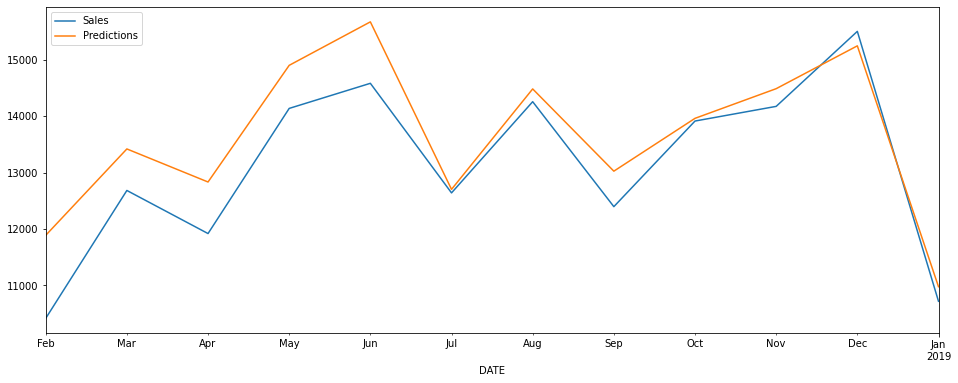

In [104]:
test.plot(figsize=(16,6))

In [106]:
model.save('forecast.h5')
from keras.models import load_model
new_model = load_model('forecast.h5')
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150)               91200     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


We can also forecast for 50 timesteps into the feature by changing len(test) ----> 50, to add those predictions into the orifinal dataset, add the timestamps corresponding to future timestamps and then plot.